In [35]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['train_FD001.txt', 'RUL_FD001.txt', 'test_FD001.txt']


# Read data and understanding data

In [36]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [37]:
train=pd.read_csv("../input/train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("../input/test_FD001.txt",sep=" ",names=columns)
test_results=pd.read_csv("../input/RUL_FD001.txt",sep=" ",header=None)

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
id          20631 non-null int64
cycle       20631 non-null int64
op1         20631 non-null float64
op2         20631 non-null float64
op3         20631 non-null float64
sensor1     20631 non-null float64
sensor2     20631 non-null float64
sensor3     20631 non-null float64
sensor4     20631 non-null float64
sensor5     20631 non-null float64
sensor6     20631 non-null float64
sensor7     20631 non-null float64
sensor8     20631 non-null float64
sensor9     20631 non-null float64
sensor10    20631 non-null float64
sensor11    20631 non-null float64
sensor12    20631 non-null float64
sensor13    20631 non-null float64
sensor14    20631 non-null float64
sensor15    20631 non-null float64
sensor16    20631 non-null float64
sensor17    20631 non-null int64
sensor18    20631 non-null int64
sensor19    20631 non-null float64
sensor20    20631 non-null float64
sensor21    20631 non-nu

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
id          13096 non-null int64
cycle       13096 non-null int64
op1         13096 non-null float64
op2         13096 non-null float64
op3         13096 non-null float64
sensor1     13096 non-null float64
sensor2     13096 non-null float64
sensor3     13096 non-null float64
sensor4     13096 non-null float64
sensor5     13096 non-null float64
sensor6     13096 non-null float64
sensor7     13096 non-null float64
sensor8     13096 non-null float64
sensor9     13096 non-null float64
sensor10    13096 non-null float64
sensor11    13096 non-null float64
sensor12    13096 non-null float64
sensor13    13096 non-null float64
sensor14    13096 non-null float64
sensor15    13096 non-null float64
sensor16    13096 non-null float64
sensor17    13096 non-null int64
sensor18    13096 non-null int64
sensor19    13096 non-null float64
sensor20    13096 non-null float64
sensor21    13096 non-nu

In [40]:
train.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [41]:
print('Unique ID: ',train.id.unique())

Unique ID:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


# Engine cycle lifetime

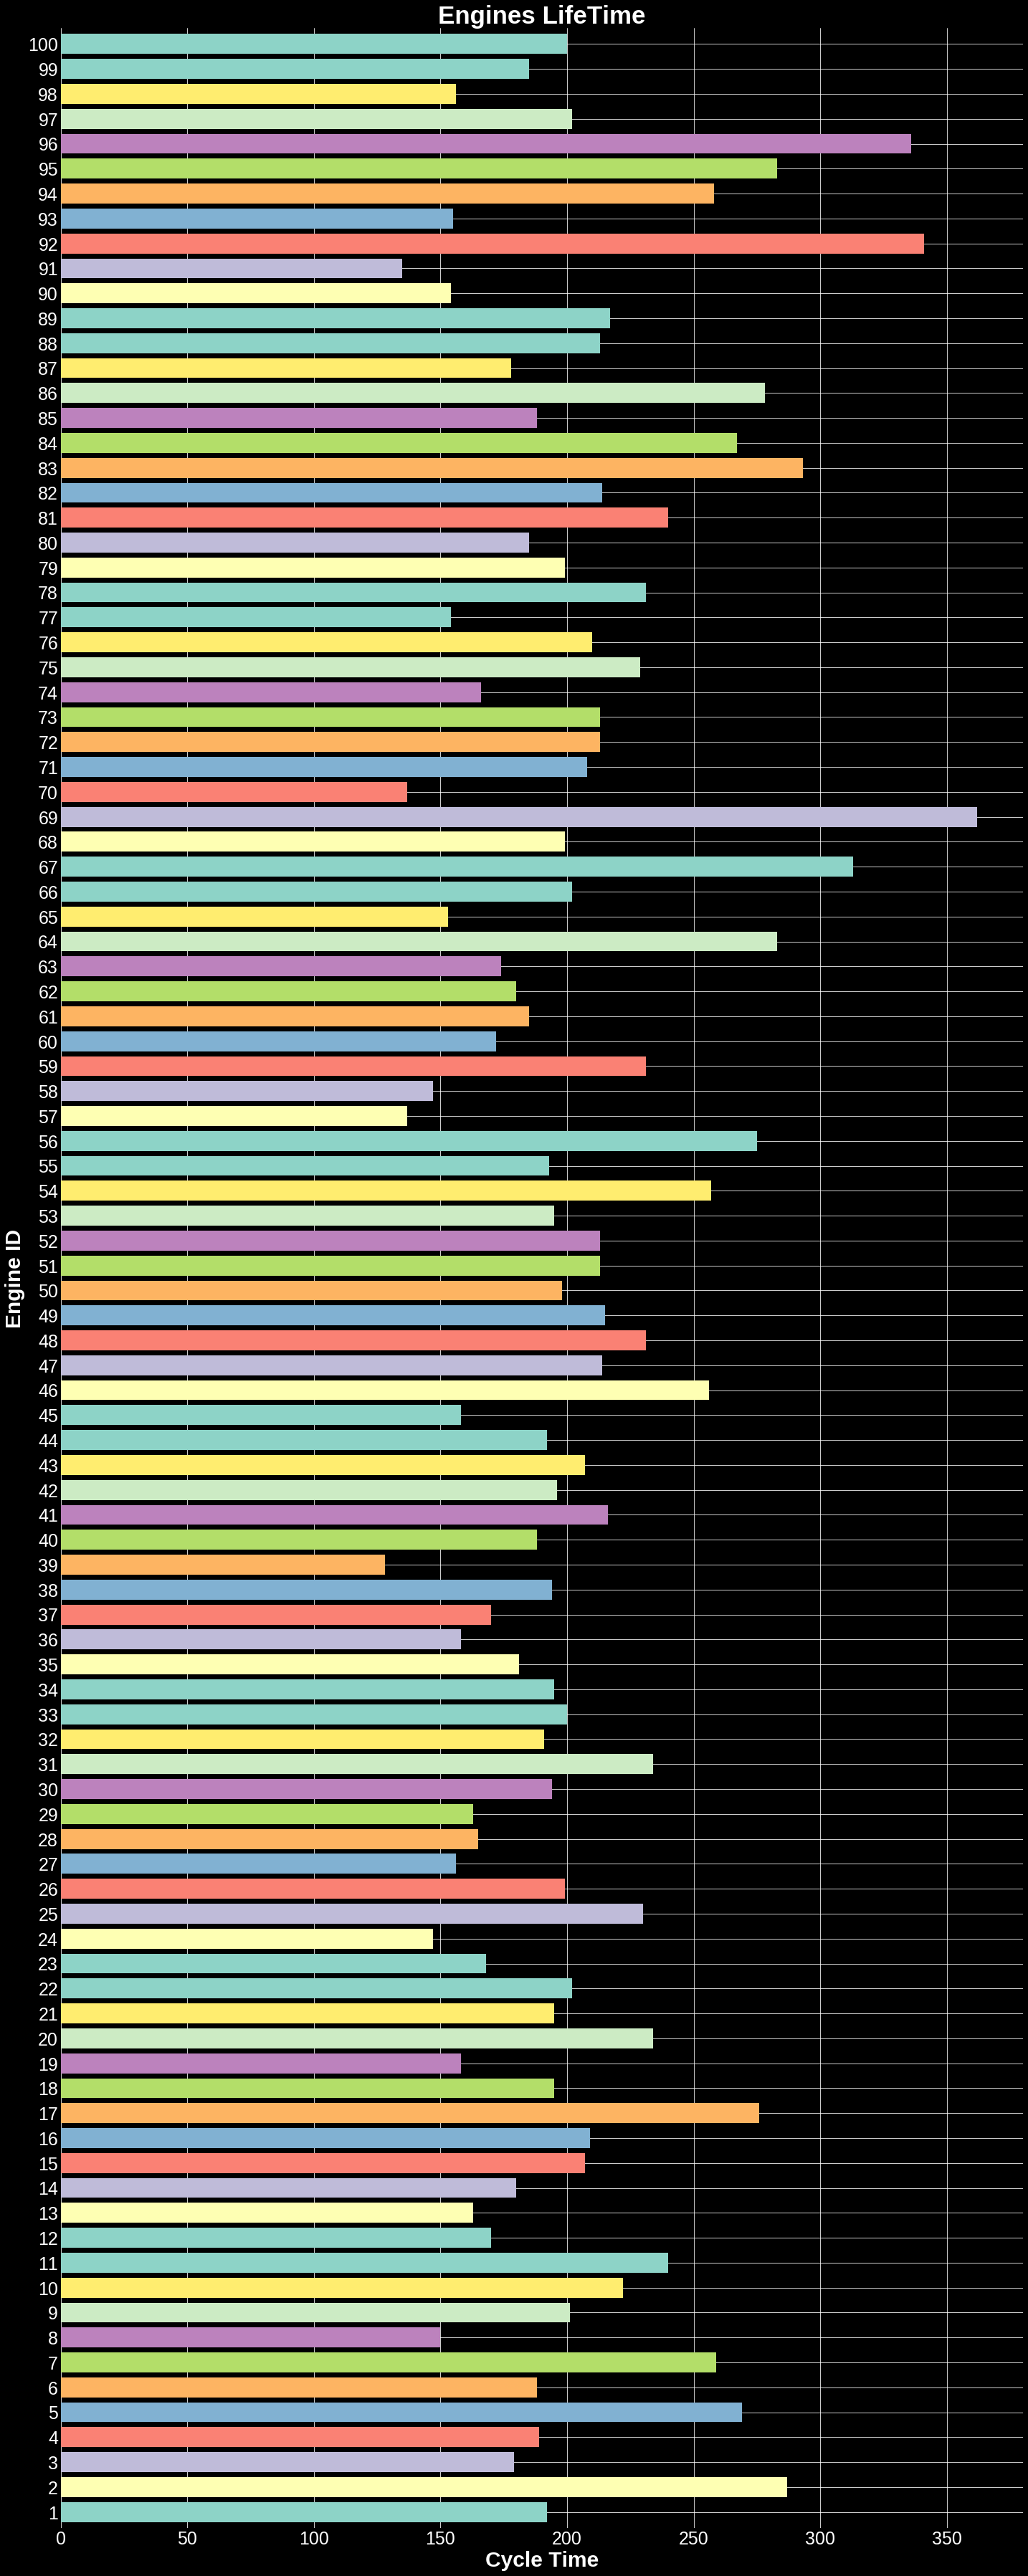

In [42]:
plt.style.use('dark_background')
plt.figure(figsize=(20,50))
ax=train.groupby('id')['cycle'].max().plot(kind='barh',width=0.8, stacked=True,align='center',rot=0)
plt.title('Engines LifeTime',fontweight='bold',size=35)
plt.xlabel('Cycle Time',fontweight='bold',size=30)
plt.xticks(size=25)
plt.ylabel('Engine ID',fontweight='bold',size=30)
plt.yticks(size=25)
plt.grid(True)
plt.tight_layout(True)
plt.show()

In [43]:
test_results.columns=["rul","null"]
test_results.head()

,rul,null
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [44]:
test_results.drop(["null"],axis=1,inplace=True)
test_results['id']=test_results.index+1
test_results.head()

,rul,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [45]:
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

In [46]:
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [47]:
test_results['rul_failed']=test_results['rul']+rul['max']
test_results.head()

,rul,id,rul_failed
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [48]:
test_results.drop(["rul"],axis=1,inplace=True)

In [49]:
test=test.merge(test_results,on=['id'],how='left')

In [50]:
test["remaining_cycle"]=test["rul_failed"]-test["cycle"]
test.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,rul_failed,remaining_cycle
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,143,138


In [51]:
test.isnull().sum()

id                     0
cycle                  0
op1                    0
op2                    0
op3                    0
sensor1                0
sensor2                0
sensor3                0
sensor4                0
sensor5                0
sensor6                0
sensor7                0
sensor8                0
sensor9                0
sensor10               0
sensor11               0
sensor12               0
sensor13               0
sensor14               0
sensor15               0
sensor16               0
sensor17               0
sensor18               0
sensor19               0
sensor20               0
sensor21               0
sensor22           13096
sensor23           13096
rul_failed             0
remaining_cycle        0
dtype: int64

In [52]:
df_train=train.drop(["sensor22","sensor23"],axis=1)
df_test=test.drop(["sensor22","sensor23"],axis=1)

In [53]:
df_test.drop(["rul_failed"],axis=1,inplace=True)
df_test.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'remaining_cycle'],
      dtype='object')

In [54]:
df_train['remaining_cycle'] = df_train.groupby(['id'])['cycle'].transform(max)-df_train['cycle']

In [55]:
df_train.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,remaining_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


# Let's look at the cycle of the motor with ID = 1

In [56]:
cycle=30
df_train['label'] = df_train['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)
df_test['label'] = df_test['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)

In [57]:
op_set=["op"+str(i) for i in range(1,4)]
sensor=["sensor"+str(i) for i in range(1,22)]

In [58]:
test.id.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

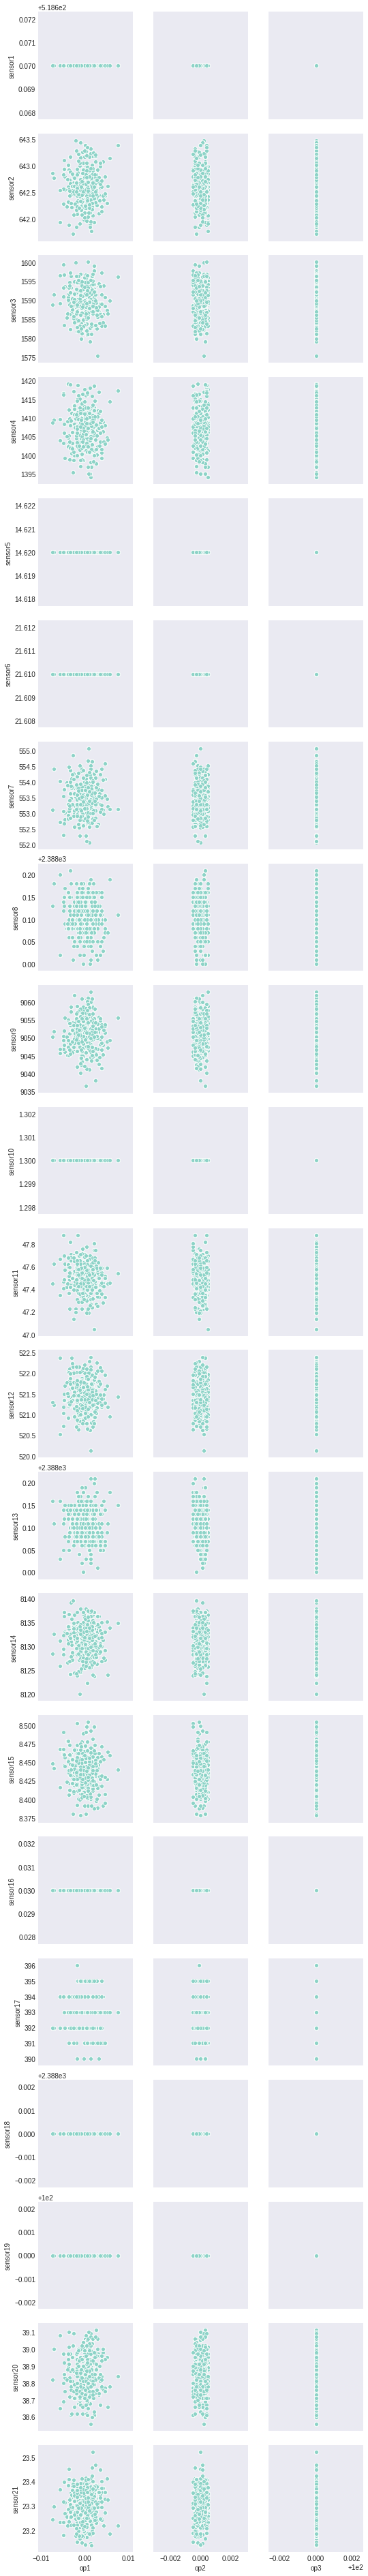

In [59]:
plt.style.use('seaborn-dark')
ax=sb.pairplot(test.query("cycle"),x_vars=op_set,y_vars=sensor,palette="husl")

In [60]:
df_train.label.unique()

array([0, 1])

In [61]:
df_test.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,remaining_cycle,label
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [62]:
df_test.columns

Index(['id', 'cycle', 'op1', 'op2', 'op3', 'sensor1', 'sensor2', 'sensor3',
       'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9',
       'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21',
       'remaining_cycle', 'label'],
      dtype='object')

# Removingthe useless variables

In [63]:
df_test.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)

In [64]:
df_test.label.unique()

array([0, 1])

In [65]:
x=df_train.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)
y=df_train.label
print('x shape : ',x.shape)
print('y shape : ',y.shape)

x shape :  (20631, 16)
y shape :  (20631,)


# Create Model

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=3)
# gc.collect()  
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 16)
X_test shape :  (4127, 16)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [67]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

# Create a LightGBM regressor model
lgb_regressor = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=5000, num_leaves=100, objective='regression', random_state=50, n_jobs=-1)

# Fit the regressor model to your training data
lgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
preds = lgb_regressor.predict(X_test)

# Evaluate the regression model
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print('Mean Squared Error (MSE): ', mse)
print('R-squared (R2) Score: ', r2)


Mean Squared Error (MSE):  0.03035524946796743
R-squared (R2) Score:  0.7603065186609796
